# 🌳 Gradient Boosting on Decision Trees Classification (XGBoost & Custom)

In this notebook, we explore bagging classification using:

- **Synthetic data** with Gaussian noise
- **XGBoost's `XGBClassifier`**
- A **custom implementation of gradient boosting using a binary decision tree**
  
Evaluation metrics and visualizations are included to compare both implementations.

In [1]:
from collections import deque
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from colorama import Fore, Style
from numpy.random import Generator as RandomGenerator
from numpy.typing import NDArray
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

## 🛠️ Utils

In [2]:
def evaluate_classification(
    y_true: NDArray[np.int64], y_pred: NDArray[np.int64]
) -> dict[str, float]:
    """Print and return classification metrics.

    Args:
        y_true (NDArray[np.int64]): Ground truth labels.
        y_pred (NDArray[np.int64]): Predicted labels.

    Returns:
        dict[str, float]: Dictionary with accuracy, precision, recall, and F1-score.
    """
    accuracy: float = accuracy_score(y_true, y_pred)
    precision: float = precision_score(
        y_true, y_pred, average="weighted", zero_division=0
    )
    recall: float = recall_score(y_true, y_pred, average="weighted", zero_division=0)
    f1: float = f1_score(y_true, y_pred, average="weighted", zero_division=0)

    print(f"{Fore.CYAN}Accuracy:  {Style.RESET_ALL}{accuracy:.4f}")
    print(f"{Fore.CYAN}Precision: {Style.RESET_ALL}{precision:.4f}")
    print(f"{Fore.CYAN}Recall:    {Style.RESET_ALL}{recall:.4f}")
    print(f"{Fore.CYAN}F1 Score:  {Style.RESET_ALL}{f1:.4f}")

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [3]:
def plot_confusion_matrix(y_true: NDArray[np.int64], y_pred: NDArray[np.int64]) -> None:
    """Display a confusion matrix using seaborn heatmap.

    Args:
        y_true (NDArray[np.int64]): True labels.
        y_pred (NDArray[np.int64]): Predicted labels.
    """
    conf_matrix = confusion_matrix(y_true, y_pred)

    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
    )
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()


def plot_clusters(
    data: NDArray[np.float64],
    centers: NDArray[np.float64],
    X_test: NDArray[np.float64],
    predicted: NDArray[np.int64],
    labels: NDArray[np.int64],
) -> None:
    """Plot original clusters and predictions on test data.

    Args:
        data (NDArray[np.float64]): Original dataset (n_samples, 2).
        centers (NDArray[np.float64]): Cluster centers (n_clusters, 2).
        X_test (NDArray[np.float64]): Test data points (n_test_samples, 2).
        predicted (NDArray[np.int64]): Predicted cluster labels or outputs.
        labels (NDArray[np.int64]): Ground truth labels for training data.
    """
    _, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Plot original data and cluster centers
    sns.scatterplot(
        x=data[:, 0],
        y=data[:, 1],
        hue=labels,
        alpha=0.5,
        palette="Set2",
        ax=axes[0],
    )
    axes[0].scatter(
        centers[:, 0],
        centers[:, 1],
        c="black",
        s=100,
        marker="x",
        label="Centers",
    )
    axes[0].set_title("Original Data and Cluster Centers")
    axes[0].legend()

    # Plot predictions
    axes[1].scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=predicted,
        cmap="tab10",
        alpha=0.5,
    )
    axes[1].set_title("Predictions on Test Data")

    plt.tight_layout()
    plt.show()

## 📊 Generate Dataset

In [4]:
def generate_data(
    n_per_cluster: int,
    num_clusters: int,
    space_size: float,
    noise_level: float = 1.0,
    dim: int = 2,
    seed: int = 42,
) -> tuple[NDArray[np.float64], NDArray[np.int32], NDArray[np.float64]]:
    """Generates synthetic data for clustering.

    Args:
        n_per_cluster (int): Number of points per cluster.
        num_clusters (int): Total number of clusters.
        space_size (float): Range for generating cluster centers.
        noise_level (float): Standard deviation of Gaussian noise.
        dim (int): Dimensionality of the data.
        seed (int): Random seed.

    Returns:
        tuple[
            data (NDArray[np.float64]): Shape (num_clusters * n_per_cluster, dim)
            labels (NDArray[np.int32]): Cluster labels
            centers (NDArray[np.float64]): Cluster center coordinates
        ]
    """
    rng = np.random.default_rng(seed)

    # Generate random cluster centers
    centers = rng.uniform(0, space_size, size=(num_clusters, dim))

    total_points = n_per_cluster * num_clusters
    data = np.empty((total_points, dim))
    labels = np.empty(total_points, dtype=np.int32)

    # Generate data points around each center
    for i, center in enumerate(centers):
        start = i * n_per_cluster
        end = start + n_per_cluster
        data[start:end] = center + rng.normal(0, noise_level, size=(n_per_cluster, dim))
        labels[start:end] = i

    return data, labels, centers


# Generate dataset
data, labels, centers = generate_data(
    n_per_cluster=1000, num_clusters=2, space_size=30, noise_level=7, dim=2, seed=412
)

In [5]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42
)

## ⚙️ XGBoost Model

In [6]:
# Create and train the model
model = XGBClassifier(learning_rate=0.1, n_estimators=20, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9500
Precision: 0.9502
Recall:    0.9500
F1 Score:  0.9500


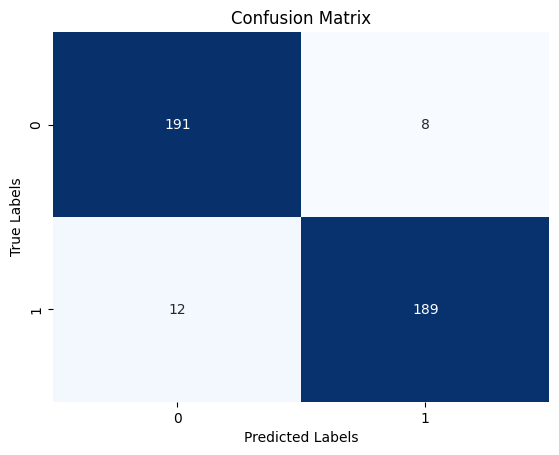

In [7]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

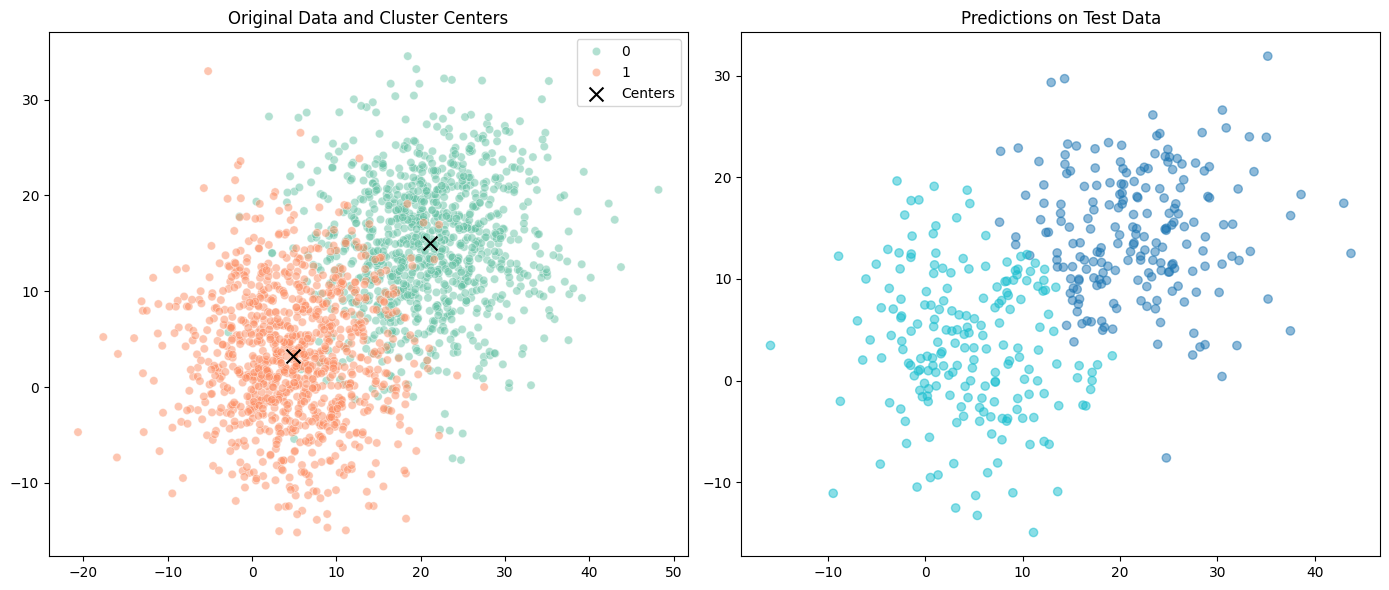

In [8]:
plot_clusters(data, centers, X_test, predicted, labels)

## 🌳 Gradient Boosting on Decision Trees Classification

In [9]:
class Node:
    """A node in the decision tree.

    Attributes:
        value (float | None): Predicted value at the leaf node.
            None if the node is not a leaf.
        feature (int | None): Index of the feature used for splitting at this node.
        threshold (float | None): Threshold value of the feature for splitting.
        left (Node | None): Left child node (samples where feature <= threshold).
        right (Node | None): Right child node (samples where feature > threshold).
    """

    def __init__(
        self,
        feature: int | None = None,
        threshold: float | None = None,
        value: float | None = None,
    ) -> None:
        """Initialize a decision tree node.

        Args:
            feature (int | None): Index of the feature to split on,
                if this node is internal.
            threshold (float | None): Threshold value to split on the feature.
            value (float | None): Predicted value if this node is a leaf.
        """
        self.value: float | None = value
        self.feature: int | None = feature
        self.threshold: float | None = threshold
        self.left: "Node" | None = None
        self.right: "Node" | None = None


class MyDecisionTreeRegressor:
    """Binary decision tree regressor using mean squared error and L1/L2 regularization.

    The tree is built by recursively splitting features to minimize impurity (variance),
    with support for limiting tree depth, minimum samples per split/leaf, random feature
    selection, and optional binning of continuous features for threshold candidates.

    Attributes:
        max_depth (int): Maximum depth of the tree.
        reg_lambda (float): L2 regularization parameter applied to leaf node values.
        reg_alpha (float): L1 regularization parameter applied to leaf node values.
        gamma (float): Minimum impurity decrease threshold to split.
        min_samples_split (int): Minimum samples required to split a node.
        min_samples_leaf (int): Minimum samples required to be at a leaf.
        max_features (int | float | Literal["sqrt", "log2"] | None): Number or
            fraction of features to consider when splitting.
        min_impurity_decrease (float): Minimum impurity decrease to perform a split.
        bins (int | None): Number of bins for discretizing continuous features
            for threshold selection.
        rng (RandomGenerator): Random number generator for reproducibility.
        root (Node | None): Root node of the fitted tree.
    """

    def __init__(
        self,
        max_depth: int,
        reg_lambda: float = 1.0,
        reg_alpha: float = 0.0,
        gamma: float = 0.0,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_features: int | float | Literal["sqrt", "log2"] | None = None,
        min_impurity_decrease: float = 0.0,
        bins: int | None = None,
        random_state: int | None = None,
    ) -> None:
        """Initialize the decision tree regressor.

        Args:
            max_depth (int): Maximum depth allowed for the tree.
            reg_lambda (float, optional): L2 regularization strength. Defaults to 1.0.
            reg_alpha (float, optional): L1 regularization strength. Defaults to 0.0.
            gamma (float): Minimum impurity decrease threshold to split.
                Defaults to 0.0.
            min_samples_split (int, optional): Minimum number of samples required
                to split an internal node. Defaults to 2.
            min_samples_leaf (int, optional): Minimum number of samples required
                to be a leaf node. Defaults to 1.
            max_features (int | float | Literal["sqrt", "log2"] | None, optional):
                Number or fraction of features to consider when looking for the best
                split. Defaults to None (all features).
            min_impurity_decrease (float, optional): Minimum impurity decrease
                to split a node. Defaults to 0.0.
            bins (int | None, optional): Number of bins for discretizing continuous
                features. If None, no binning is applied. Defaults to None.
            random_state (int | None, optional): Seed for random number generator.
                Defaults to None.
        """
        self.max_depth: int = max_depth
        self.reg_lambda: float = reg_lambda
        self.reg_alpha: float = reg_alpha
        self.gamma: float = gamma
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.max_features: int | float | str | None = max_features
        self.min_impurity_decrease: float = min_impurity_decrease
        self.bins: int | None = bins
        self.rng: RandomGenerator = np.random.default_rng(random_state)
        self.root: Node | None = None

    def _get_features(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Select a subset of feature indices based on `max_features`.

        Determines how many and which features to consider for splits, supporting
        fixed count, fraction, or special strings 'sqrt' and 'log2'.

        Args:
            X (NDArray[np.float64]): Input feature matrix (n_samples, n_features).

        Returns:
            NDArray[np.int_]: Array of selected feature indices.

        Raises:
            ValueError: If `max_features` is invalid.
        """
        feature_count = X.shape[1]

        if isinstance(self.max_features, int):
            feature_count = self.max_features
        elif isinstance(self.max_features, float):
            feature_count = int(feature_count * self.max_features)
        elif self.max_features == "sqrt":
            feature_count = int(np.sqrt(feature_count))
        elif self.max_features == "log2":
            feature_count = int(np.log2(feature_count))
        elif self.max_features is not None:
            raise ValueError(f"Unsupported max_features: {self.max_features}")

        feature_count = max(1, min(feature_count, X.shape[1]))
        return self.rng.choice(X.shape[1], feature_count, replace=False)

    def _squared_error(self, y: NDArray[np.float64]) -> float:
        """Calculate variance (mean squared error) of target values.

        Args:
            y (NDArray[np.float64]): Target values.

        Returns:
            float: Variance of y, or 0 if y is empty.
        """
        if len(y) == 0:
            return 0.0

        return np.mean((y - np.mean(y)) ** 2)

    def _split_dataset(
        self,
        X: NDArray[np.float64],
        y: NDArray[np.float64],
        feature_index: int,
        threshold: float,
    ) -> tuple[
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
        NDArray[np.float64],
    ]:
        """Split dataset into left and right subsets based on feature threshold.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Target vector.
            feature_index (int): Feature index to split on.
            threshold (float): Threshold value.

        Returns:
            Tuple containing:
                - X_left, y_left: samples where feature <= threshold.
                - X_right, y_right: samples where feature > threshold.
        """
        left_mask = X[:, feature_index] <= threshold
        right_mask = X[:, feature_index] > threshold
        return X[left_mask], y[left_mask], X[right_mask], y[right_mask]

    def _get_thresholds_from_bins(
        self, x_column: NDArray[np.float64]
    ) -> NDArray[np.float64]:
        """Generate candidate thresholds from feature values.

        If `bins` is set, thresholds are midpoints of histogram bins.
        Otherwise, thresholds are midpoints between sorted unique values.

        Args:
            x_column (NDArray[np.float64]): 1D feature column.

        Returns:
            NDArray[np.float64]: Candidate split thresholds.
        """
        if self.bins is None or self.bins < 1:
            x_column_sorted = np.sort(np.unique(x_column))
            thresholds = (x_column_sorted[:-1] + x_column_sorted[1:]) / 2
        else:
            bin_edges = np.histogram_bin_edges(x_column, bins=self.bins)
            thresholds = (bin_edges[:-1] + bin_edges[1:]) / 2

        return thresholds

    def _best_split(
        self, X: NDArray[np.float64], y: NDArray[np.float64]
    ) -> tuple[int, float]:
        """Find the best feature and threshold to split the dataset.

        Args:
            X (NDArray[np.float64]): Feature matrix.
            y (NDArray[np.float64]): Target vector.

        Returns:
            Tuple[int | None, float | None]: Best feature index and threshold.
                None if no valid split.
        """
        best_feature: int | None = None
        best_threshold: float | None = None
        best_impurity: float = float("-inf")

        current_impurity = self._squared_error(y)

        for feature_index in self._get_features(X):
            thresholds = self._get_thresholds_from_bins(X[:, feature_index])
            for threshold in thresholds:
                _, y_left, _, y_right = self._split_dataset(
                    X, y, feature_index, threshold
                )
                if (
                    len(y_left) < self.min_samples_leaf
                    or len(y_right) < self.min_samples_leaf
                ):
                    continue

                left_impurity = self._squared_error(y_left)
                right_impurity = self._squared_error(y_right)
                weighted_impurity = (
                    len(y_left) * left_impurity + len(y_right) * right_impurity
                ) / len(y)
                impurity_decrease = current_impurity - weighted_impurity
                if (
                    impurity_decrease <= best_impurity
                    or impurity_decrease < self.min_impurity_decrease
                    or impurity_decrease < self.gamma
                ):
                    continue

                best_impurity = impurity_decrease
                best_threshold = threshold
                best_feature = feature_index

        return best_feature, best_threshold

    def _calculate_node_value(self, y_node: NDArray[np.float64]) -> float:
        """Compute leaf node value with L1 and L2 regularization.

        Args:
            y_node (NDArray[np.float64]): Target values at the node.

        Returns:
            float: Regularized prediction value for the node.
        """
        n = len(y_node)
        if n == 0:
            return 0.0

        # Calculate the mean value adjusted by L2 regularization
        node_value = np.sum(y_node) / (n + self.reg_lambda)

        # Apply L1 regularization (soft thresholding)
        if node_value > self.reg_alpha:
            node_value -= self.reg_alpha
        elif node_value < -self.reg_alpha:
            node_value += self.reg_alpha
        else:
            node_value = 0.0

        return node_value

    def fit(self, X: NDArray[np.float64], y: NDArray[np.float64]) -> None:
        """Fit the decision tree to the training data using breadth-first growth.

        The tree is grown level by level. Splits are made if they meet criteria for
        impurity decrease, minimum samples, and depth limits.

        Args:
            X (NDArray[np.float64]): Training features (n_samples, n_features).
            y (NDArray[np.float64]): Training targets (n_samples,).
        """
        self.root = Node()
        queue: deque[tuple[Node, NDArray[np.float64], NDArray[np.float64], int]] = (
            deque()
        )
        queue.append((self.root, X, y, 0))

        while queue:
            node, X_node, y_node, depth = queue.popleft()

            if (
                len(np.unique(y_node)) == 1
                or len(y_node) < self.min_samples_split
                or depth == self.max_depth
            ):
                node.value = self._calculate_node_value(y_node)
                continue

            feature, threshold = self._best_split(X_node, y_node)
            if feature is None:
                node.value = self._calculate_node_value(y_node)
                continue

            node.feature = feature
            node.threshold = threshold

            X_left, y_left, X_right, y_right = self._split_dataset(
                X_node, y_node, feature, threshold
            )

            if (
                len(y_left) < self.min_samples_split
                or len(y_right) < self.min_samples_split
            ):
                node.value = self._calculate_node_value(y_node)
                continue

            node.left = Node()
            node.right = Node()
            queue.append((node.left, X_left, y_left, depth + 1))
            queue.append((node.right, X_right, y_right, depth + 1))

    def _predict_one(self, x: NDArray[np.float64], node: Node | None = None) -> int:
        """Predict target value for a single sample by traversing the tree.

        Args:
            x (NDArray[np.float64]): Single input sample.
            node (Node | None, optional): Current node during recursion.
                Defaults to root.

        Returns:
            float: Predicted target value.
        """
        if node is None:
            node = self.root

        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        return self._predict_one(x, node.right)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.float64]:
        """Predict target values for a batch of samples.

        Args:
            X (NDArray[np.float64]): Input feature matrix (n_samples, n_features).

        Returns:
            NDArray[np.float64]: Predicted target values.
        """
        return np.array([self._predict_one(x) for x in X])

In [10]:
class MyGBDTClassifier:
    """Gradient Boosted Decision Tree classifier for binary classification.

    This classifier builds an ensemble of decision trees sequentially, where
    each new tree attempts to correct the errors of the previous ensemble by
    fitting to the residuals (negative gradients) of the logistic loss function.
    Supports regularization, feature subsampling, and optional binning for split
    thresholds.

    Attributes:
        learning_rate (float): Shrinkage factor applied to each tree's contribution.
        n_estimators (int): Number of boosting iterations (trees).
        max_depth (int): Maximum depth allowed for each tree.
        reg_lambda (float): L2 regularization strength on leaf values.
        reg_alpha (float): L1 regularization strength on leaf values.
        gamma (float): Minimum loss reduction required to make a split.
        min_samples_split (int): Minimum samples needed to split an internal node.
        min_samples_leaf (int): Minimum samples required at a leaf node.
        max_samples (float): Fraction of samples used for training each tree.
        max_features (int | float | Literal["sqrt", "log2"] | None): Number or
            fraction of features to consider when looking for the best split.
        min_impurity_decrease (float): Minimum impurity decrease to perform a split.
        bins (int | None): Number of bins to discretize continuous features for
            split candidates.
        rng (np.random.Generator): Random number generator instance.
        trees (list[MyDecisionTreeRegressor]): List of fitted regression trees.
        F0 (float | None): Initial prediction log-odds before any boosting.
    """

    def __init__(
        self,
        learning_rate: float,
        n_estimators: int,
        max_depth: int,
        reg_lambda: float = 1.0,
        reg_alpha: float = 0.0,
        gamma: float = 0.0,
        min_samples_split: int = 2,
        min_samples_leaf: int = 1,
        max_samples: float = 1.0,
        max_features: int | float | Literal["sqrt", "log2"] | None = "sqrt",
        min_impurity_decrease: float = 0.0,
        bins: int | None = None,
        random_state: int | None = None,
    ) -> None:
        """Initialize the Gradient Boosted Decision Tree classifier.

        Args:
            learning_rate (float): Step size shrinkage applied to each tree's output.
            n_estimators (int): Number of boosting rounds (trees) to fit.
            max_depth (int): Maximum depth of each individual tree.
            reg_lambda (float, optional): L2 regularization on leaf weights.
                Default is 1.0.
            reg_alpha (float, optional): L1 regularization on leaf weights.
                Default is 0.0.
            gamma (float, optional): Minimum loss reduction to create a split.
                Default is 0.0.
            min_samples_split (int, optional): Minimum number of samples required
                to split a node. Default is 2.
            min_samples_leaf (int, optional): Minimum number of samples required to be
                at a leaf node. Default is 1.
            max_samples (float, optional): Fraction of training samples used to fit
                each tree. Default is 1.0.
            max_features (int | float | Literal["sqrt", "log2"] | None, optional):
                Number or fraction of features to consider when looking for
                the best split. Default is "sqrt".
            min_impurity_decrease (float, optional): Minimum impurity decrease
                required to split. Default is 0.0.
            bins (int | None, optional): Number of bins for discretizing continuous
                features. Default is None (no binning).
            random_state (int | None, optional): Seed for random number generator
                for reproducibility. Default is None.
        """
        self.learning_rate: float = learning_rate
        self.n_estimators: int = n_estimators
        self.max_depth: int = max_depth
        self.reg_lambda: float = reg_lambda
        self.reg_alpha: float = reg_alpha
        self.gamma: float = gamma
        self.max_samples: float = max_samples
        self.min_samples_split: int = min_samples_split
        self.min_samples_leaf: int = min_samples_leaf
        self.max_features: int | float | str | None = max_features
        self.min_impurity_decrease: float = min_impurity_decrease
        self.bins: int | None = bins
        self.rng = np.random.default_rng(random_state)
        self.trees: list[Node] = []
        self.F0: Node | None = None

    def _sigmoid(self, z: NDArray[np.float64]) -> NDArray[np.float64]:
        """Compute the sigmoid activation function.

        Args:
            z (NDArray[np.float64]): Input array (can be a scalar, vector, or matrix).

        Returns:
            NDArray[np.float64]: Output after applying the sigmoid function.
        """
        return 1 / (1 + np.exp(-z))

    def _compute_initial_logit(self, y: NDArray[np.int64]) -> float:
        """Calculate the initial log-odds of the positive class.

        Args:
            y (NDArray[np.int64]): Binary target labels.

        Returns:
            float: Initial prediction in log-odds space.
        """
        p = np.clip(np.mean(y), 1e-5, 1 - 1e-5)
        return np.log(p / (1 - p))

    def _compute_gradient(
        self, y_true: NDArray[np.int64], y_pred_logit: NDArray[np.int64]
    ) -> NDArray[np.int64]:
        """Compute the gradient of the logistic loss.

        Args:
            y_true (NDArray[np.int64]): True binary labels.
            y_pred_logit (NDArray[np.float64]): Current predictions in log-odds space.

        Returns:
            NDArray[np.float64]: Residuals (negative gradients) for boosting.
        """
        prob = self._sigmoid(y_pred_logit)
        return y_true - prob

    def fit(self, X: NDArray[np.float64], y: NDArray[np.int64]) -> None:
        """Fit the Gradient Boosted Decision Tree classifier to training data.

        Args:
            X (NDArray[np.float64]): Training features, shape (n_samples, n_features).
            y (NDArray[np.int64]): Binary target labels, shape (n_samples,).
        """
        self.F0 = self._compute_initial_logit(y)
        Fm = np.full_like(y, self.F0, dtype=np.float64)
        self.trees.clear()

        for _ in range(self.n_estimators):
            residuals = self._compute_gradient(y, Fm)

            tree = MyDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                min_impurity_decrease=self.min_impurity_decrease,
                bins=self.bins,
                random_state=self.rng.integers(1_000_000),
            )
            tree.fit(X, residuals)
            self.trees.append(tree)

            Fm += self.learning_rate * tree.predict(X)

    def predict(self, X: NDArray[np.float64]) -> NDArray[np.int64]:
        """Predict binary class labels for input samples.

        Args:
            X (NDArray[np.float64]): Input features, shape (n_samples, n_features).

        Returns:
            NDArray[np.int64]: Predicted binary class labels.
        """
        Fm = np.full(X.shape[0], self.F0, dtype=np.float64)
        for tree in self.trees:
            Fm += self.learning_rate * tree.predict(X)
        prob = self._sigmoid(Fm)
        return (prob >= 0.5).astype(int)

In [11]:
# Create and train the model
model = MyGBDTClassifier(
    learning_rate=0.1, n_estimators=20, max_depth=3, random_state=42
)
model.fit(X_train, y_train)

# Predict on test data
predicted = model.predict(X_test)

Accuracy:  0.9350
Precision: 0.9357
Recall:    0.9350
F1 Score:  0.9350


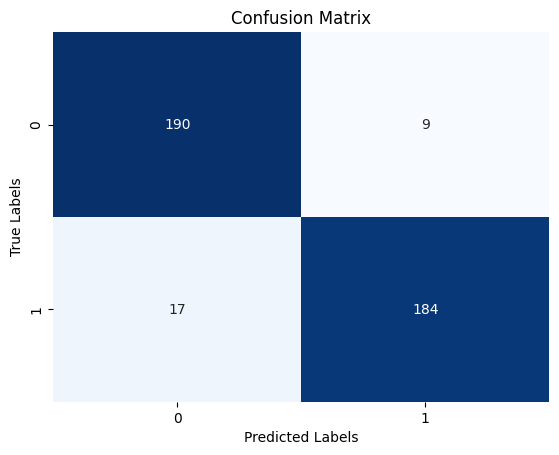

In [12]:
evaluate_classification(y_test, predicted)
plot_confusion_matrix(y_test, predicted)

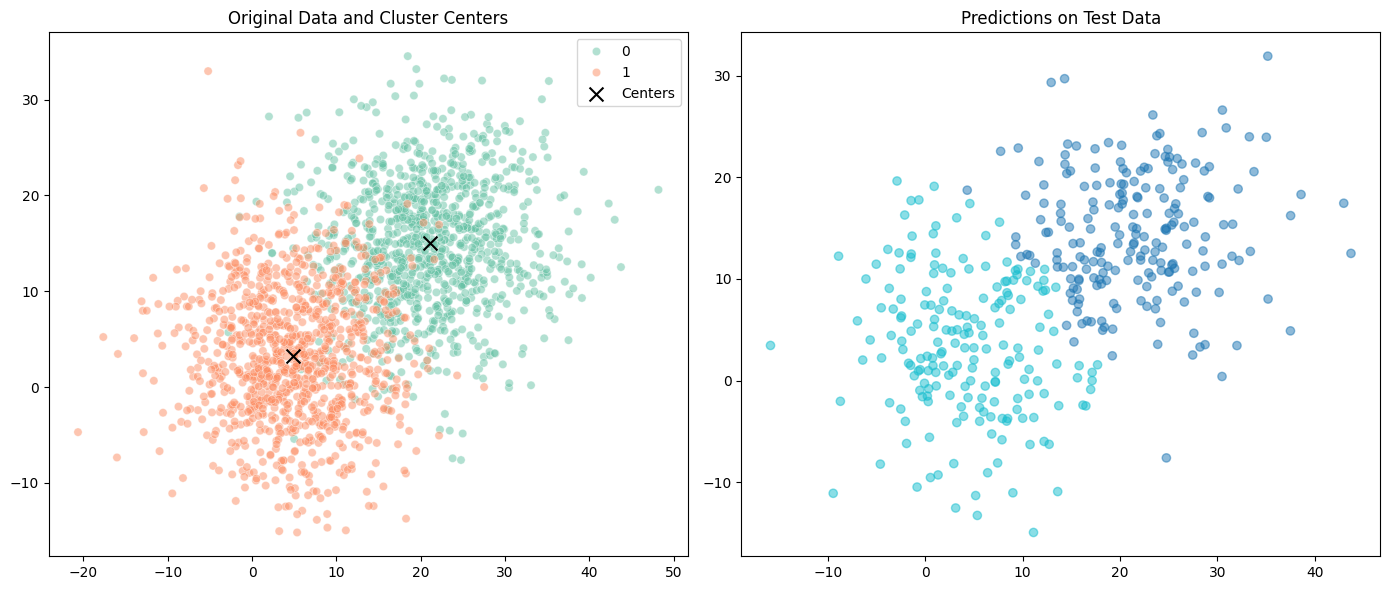

In [13]:
plot_clusters(data, centers, X_test, predicted, labels)